In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import os

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers



In [4]:
def load_images_from_folder(folder,eyes):
    images=[]
    for filename in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,filename))
        img=cv2.resize(img,(80,80))
        images.append([img,eyes])
    return images

In [5]:

folder="/content/drive/MyDrive/train/Open_Eyes"
open_eyes=load_images_from_folder(folder,0)

folder="/content/drive/MyDrive/train/Closed_Eyes"
closed_eyes=load_images_from_folder(folder,1)


In [6]:
#Number of Images
#
print(len(open_eyes))
print(len(closed_eyes))

2000
2000


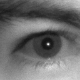

In [7]:
#Displaying image to confirm that they have been loaded 
from PIL import Image as im
data=im.fromarray(open_eyes[0][0])
data

In [8]:
#Combining the open and closed eye data 
eyes=open_eyes+closed_eyes

In [9]:
#Setting up images with X being images and y being labels
X=[]
y=[]

for features, label in eyes:
    X.append(features)
    y.append(label)



In [10]:
#Converting image to array for modelling and scaling by dividing by 255
X=np.array(X).reshape(-1,80,80,3)
y=np.array(y)
X=X/255.0

In [11]:
# Splitting the data 

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=23 )


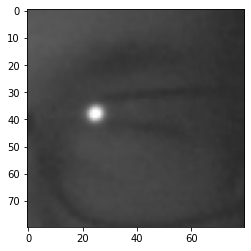

In [12]:
#confirming that split ran okay

plt.figure()
plt.imshow(X_train[10])
plt.show()

In [13]:
#class names for images shown below 

class_names=['open','close']

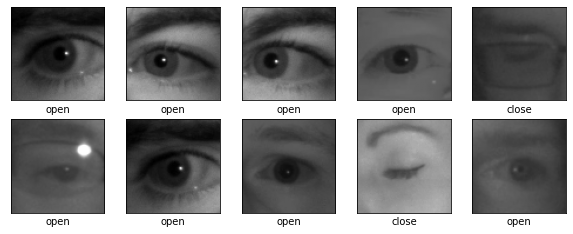

In [14]:
#producing images of training set with corresponding label
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]],)

In [15]:
#Reshping imags to 80*80*3 just incase 
X_train=X_train.reshape(X_train.shape[0], 80,80,3)
X_test=X_test.reshape(X_test.shape[0], 80,80,3)

In [24]:
def deep_learning_model(dense_neurons1=128,dense_neurons2=128,dense_neurons3=128,layout='',filters=32,dropout=None,pooling=None):
  model=Sequential()
  if layout== '5x5':
    model.add(Conv2D(filters=filters, kernel_size=(5,5),activation='relu',input_shape=(80,80,3)))

  if layout=='3x3'or layout== '2*3x3':
    model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))

#adding pooling for convlutional layers
  if pooling!=None:
    model.add(MaxPooling2D(pool_size=(2,2)))

  if layout=='2*3x3':
    #second layer
      model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))
#adding pooling on 2*3x3
  if pooling !=None and layout =='2*3x3':
    model.add(MaxPooling2D(pool_size=(2,2)))

#flatten model for dense layers
  model.add(Flatten())
  model.add(Dense(dense_neurons1,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons2,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons3,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))

#adding output layer

  model.add(Dense(1,activation='sigmoid'))

  #compiling using binary cross entropy and using AUC as metric 
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.AUC(curve='PR')])

  return model







    


In [25]:
early_stop=tf.keras.callbacks.EarlyStopping(patience=5, min_delta=.05)

In [26]:
params_deep={
    "layout":['3x3','5x5','2*3x3'],
    "dense_neurons1":[64,128],
    'filters':[8,18,32],
    "dropout":[0.1,0.5,],
    "pooling":[None,1],
    "epochs":[10]

}

In [27]:
nn_deep=KerasClassifier(build_fn=deep_learning_model, batch_size=200)
gs_deep=GridSearchCV(estimator=nn_deep,param_grid=params_deep,cv=3,scoring='average_precision')
gs_deep.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Epoch 1/10
10/10 [==============================] - 14s 71ms/step - loss: 0.7723 - auc_651: 0.5630 - val_loss: 0.6908 - val_auc_651: 0.8337
Epoch 2/10
10/10 [==============================] - 0s 30ms/step - loss: 0.5610 - auc_651: 0.8005 - val_loss: 0.4128 - val_auc_651: 0.9595
Epoch 3/10
10/10 [==============================] - 0s 30ms/step - loss: 0.3532 - auc_651: 0.9397 - val_loss: 0.2526 - val_auc_651: 0.9718
Epoch 4/10
10/10 [==============================] - 0s 28ms/step - loss: 0.2415 - auc_651: 0.9621 - val_loss: 0.1751 - val_auc_651: 0.9821
Epoch 5/10
10/10 [==============================] - 0s 28ms/step - loss: 0.1564 - auc_651: 0.9833 - val_loss: 0.1261 - val_auc_651: 0.9876
Epoch 6/10
10/10 [==============================] - 0s 28ms/step - loss: 0.1137 - auc_651: 0.9913 - val_loss: 0.0979 - val_auc_651: 0.9915
Epoch 7/10
10/10 [==============================] - 0s 28ms/step - loss: 0.0825 - auc_651: 0.9944 - val_loss: 0.0865 - val_auc_651: 0.9938
Epoch 8/10
10/10 [========

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f61d9700bd0>,
             param_grid={'dense_neurons1': [64, 128], 'dropout': [0.1, 0.5],
                         'epochs': [10], 'filters': [8, 18, 32],
                         'layout': ['3x3', '5x5', '2*3x3'],
                         'pooling': [None, 1]},
             scoring='average_precision')

In [28]:
df=pd.DataFrame(gs_deep.cv_results_)

In [29]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dense_neurons1,param_dropout,param_epochs,param_filters,param_layout,param_pooling,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.092257,5.383500,0.275241,0.039110,64,0.1,10,8,3x3,None,"{'dense_neurons1': 64, 'dropout': 0.1, 'epochs...",0.999074,0.995777,0.998369,0.997740,0.001418,22
1,4.850943,0.894673,0.224108,0.005457,64,0.1,10,8,3x3,1,"{'dense_neurons1': 64, 'dropout': 0.1, 'epochs...",0.989934,0.993230,0.993450,0.992205,0.001608,56
2,4.174746,0.133978,0.955052,0.977592,64,0.1,10,8,5x5,None,"{'dense_neurons1': 64, 'dropout': 0.1, 'epochs...",0.997666,0.999414,0.999555,0.998878,0.000859,13
3,5.455250,0.933675,0.250552,0.023654,64,0.1,10,8,5x5,1,"{'dense_neurons1': 64, 'dropout': 0.1, 'epochs...",0.998009,0.994450,0.991091,0.994517,0.002825,46
4,5.912465,0.388312,0.498046,0.355218,64,0.1,10,8,2*3x3,None,"{'dense_neurons1': 64, 'dropout': 0.1, 'epochs...",0.998368,0.999722,0.997390,0.998493,0.000956,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,5.718640,0.278995,0.249361,0.013471,128,0.5,10,32,3x3,1,"{'dense_neurons1': 128, 'dropout': 0.5, 'epoch...",0.993430,0.994762,0.994657,0.994283,0.000605,48
68,9.917515,2.138186,0.283998,0.002284,128,0.5,10,32,5x5,None,"{'dense_neurons1': 128, 'dropout': 0.5, 'epoch...",0.993531,0.997286,0.991782,0.994200,0.002296,50
69,9.536936,2.389203,0.280418,0.014363,128,0.5,10,32,5x5,1,"{'dense_neurons1': 128, 'dropout': 0.5, 'epoch...",0.991268,0.999500,0.992148,0.994305,0.003691,47
70,10.107435,0.824704,0.823367,0.720584,128,0.5,10,32,2*3x3,None,"{'dense_neurons1': 128, 'dropout': 0.5, 'epoch...",0.998968,0.998482,0.998158,0.998536,0.000333,16
